In [1]:
%matplotlib inline
import time
from notebook_init import *

out_root = Path('out/1dim')
makedirs(out_root, exist_ok=True)
rand = lambda : np.random.randint(np.iinfo(np.int32).max)
torch.autograd.set_grad_enabled(True)

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


In [2]:
use_w = True
dataset = 'ffhq'
inst = get_instrumented_model('StyleGAN', dataset, 'g_mapping', device, use_w=use_w, inst=inst)
model = inst.model
model.truncation = 1.0 # NOT IMPLEMENTED

In [3]:
''' Seed for Stylegan in GANSpace Figure 5'''
#seeds_ffhq = [440608316, 1811098088, 129888612]  #pose : axis 9
#seeds_ffhq = [1759734403, 1647189561, 70163682]  #smile : axis 44
seeds_ffhq = [1302836080, 1746672325]  #gender : axis 0
#seeds_ffhq = [1565213752, 1005764659, 1110182583]  # glasses : axis 12

start_direction = 0
n_direction = 5
num_frames = 7
layer_mode = 'all'
perturb_intensity = 5

## Local Basis

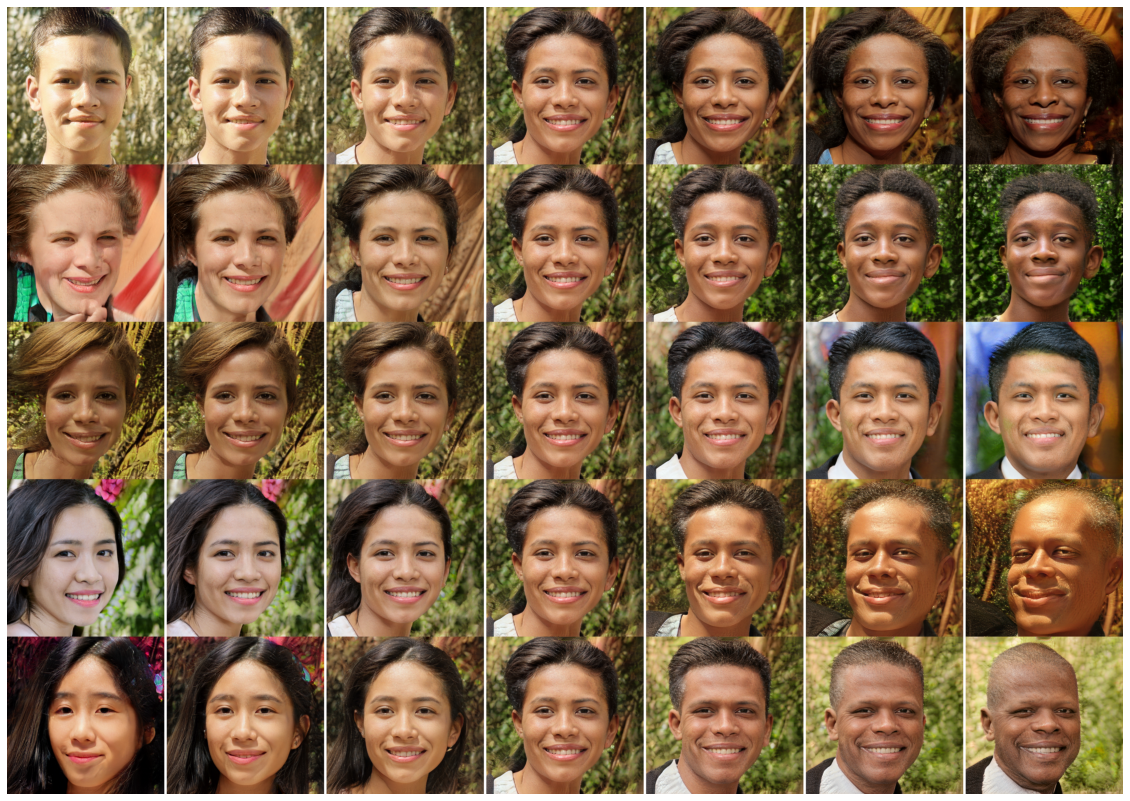

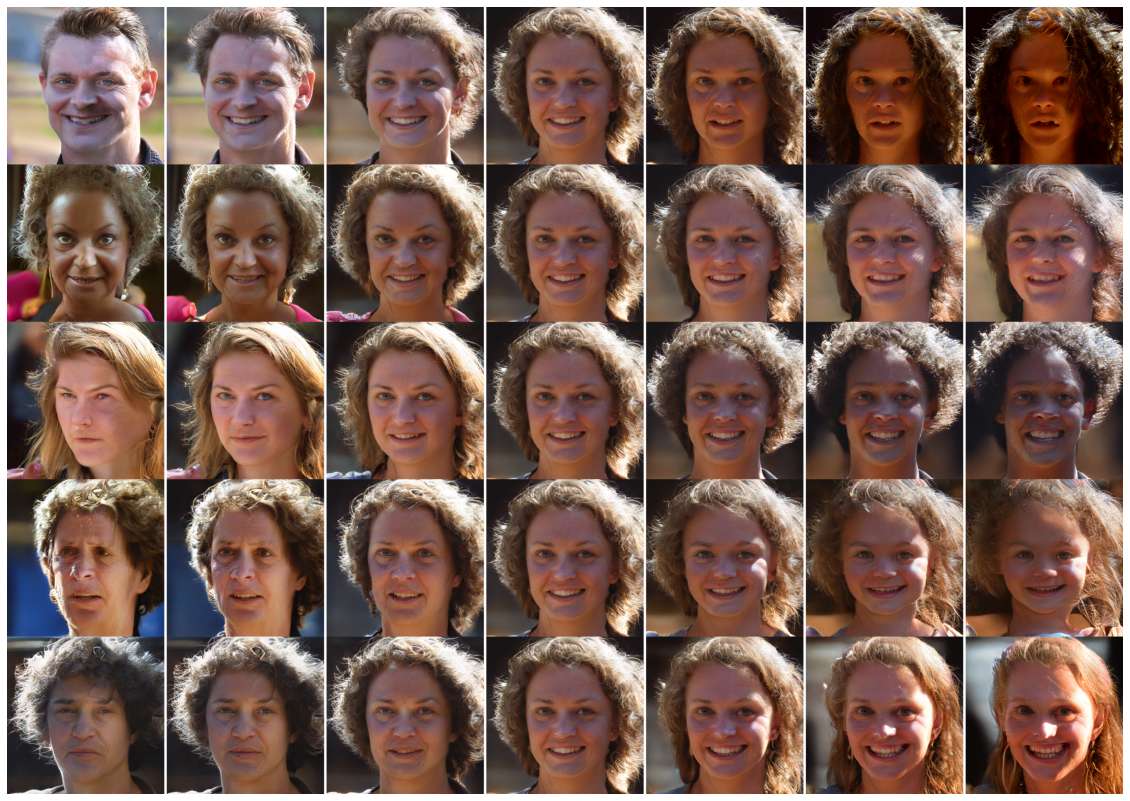

In [4]:
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    noise, z, z_local_basis, z_sv, noise_basis = get_random_local_basis(model, rng)
    lb_dir = z_local_basis.t().unsqueeze(1).detach().to(device) #reshape    
    layer_start, layer_end = LayerMode(layer_mode)    
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z], 0, lb_dir[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'LocalBasis_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

# GANSpace - Only for FFHQ

In [5]:
#gs_dir = np.load('./global_directions/ganspace_directions_ffhq_stylegan2.npy')#Note! Only ffhq is provided.
gs_dir = np.load('./global_directions/ganspace_directions_ffhq_stylegan.npy')#Note! Only ffhq is provided.
print(gs_dir.shape)
gs_dir = torch.from_numpy(gs_dir).to(device)

(128, 1, 512)


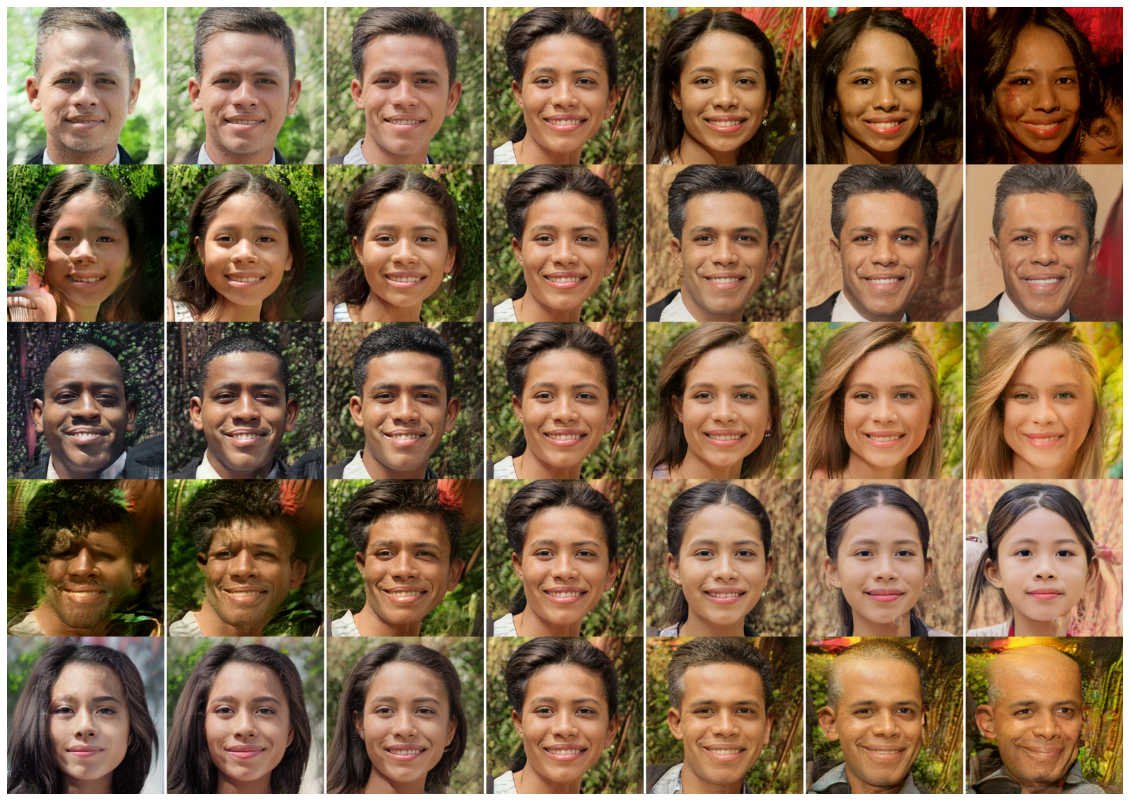

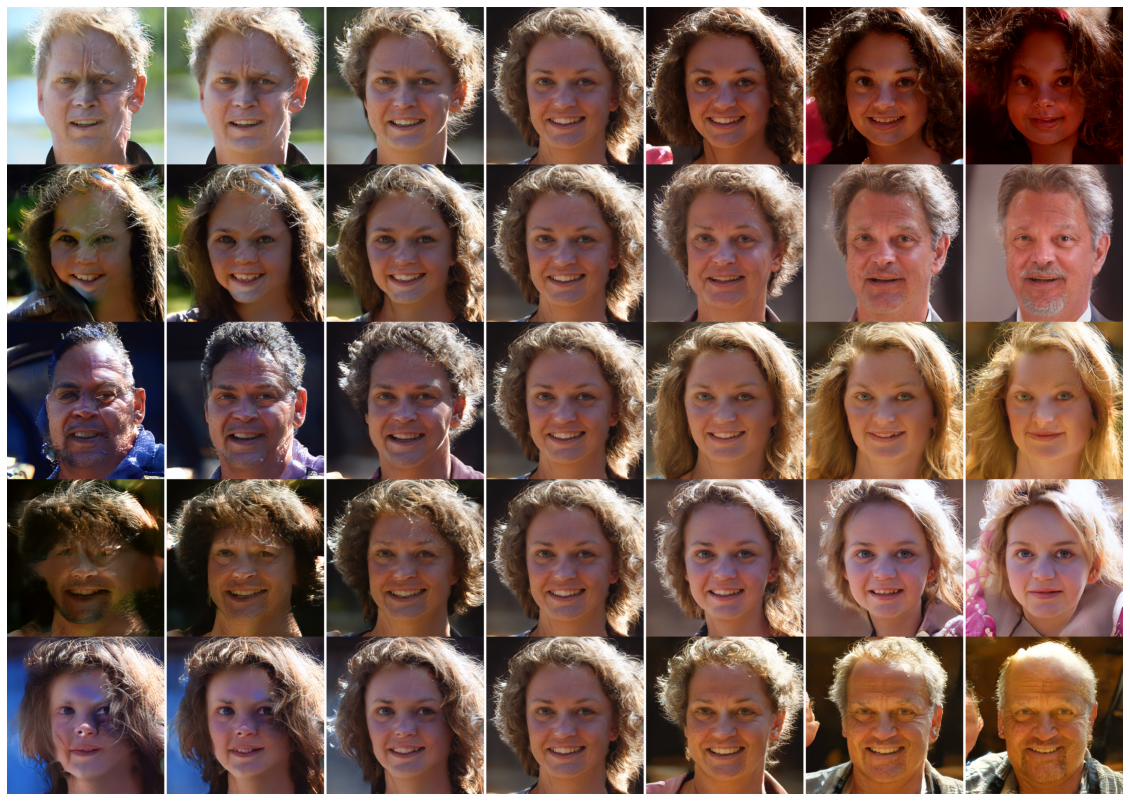

In [6]:
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    noise = torch.from_numpy(
            rng.standard_normal(512 * 1)
            .reshape(1, 512)).float().to(model.device) #[N, 512]
    if model.w_primary:
        #z = model.model.style(noise)
        z = model.model._modules['g_mapping'].forward(noise)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z], 0, gs_dir[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'ganspace_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

# SeFa - Only for FFHQ

In [ ]:
sf_dir = np.load('./global_directions/sefa_directions_ffhq.npy') #Note! Only ffhq is provided.
sf_dir = torch.from_numpy(sf_dir).to(device)

In [ ]:
save_img = False

for seed in seeds_ffhq:
    rng = np.random.RandomState(seed)
    noise = torch.from_numpy(
            rng.standard_normal(512 * 1)
            .reshape(1, 512)).float().to(model.device) #[N, 512]
    if model.w_primary:
        z = model.model.style(noise)
    layer_start, layer_end = LayerMode(layer_mode)
    strips = []
    
    with torch.no_grad():
        for i in range(start_direction, start_direction + n_direction):
            batch_frames = create_strip_centered(inst, 'latent', 'style', [z], 0, sf_dir[i], 0, 1, 0, z, perturb_intensity, layer_start, layer_end, num_frames=num_frames, only_pos=0, only_neg=0)[0]
            strips.append(np.hstack(pad_frames(batch_frames)))
    grid = np.vstack(strips)
    
    if save_img:
        Image.fromarray(np.uint8(grid*255)).save(data_path / f'sefa_{seed}_{start_direction}to{start_direction+n_direction-1}_ptb{perturb_intensity}.jpg')
    else:
        plt.figure(figsize=(20,40))
        plt.imshow(grid)
        plt.axis('off')
        plt.show()